## Assigment: Neural network basics

Soft deadline: 16.09.18 at 23.59

Hard deadline: 18.09.18 at 23.59

For this task I intentionally provide no boilerplate code, because very puprpose of this task is getting you comforatable with basic code template for desiging NNs in pytorch. I higly recommend you to revisit all the last seminar materials.

#### Task

* Implement simple **fully-convolutional** neural architecture for classification. Make sure it is small enought to run on your home machine.
* Provide dataset visulization.
* Provide train/test split and validation

#### Requirements

* Architecture should derive from `torch.nn.Module`
* Use `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. But if you manage co simplify this step using dataset `torchivision`, I will only encourage you.
* Implement at least one data transformer, but make sure it is useful for classification task.
* Use FashionMNIST dataset https://github.com/zalandoresearch/fashion-mnist
* Make sure you can fix random seed for all components of your code to make experiments reproducible
* Since you architecure should be fully-convolutional, make sure it does not depend on input size.

Многие куски кода взяты из pytorch tutorial.

In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(10)

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress',
           'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

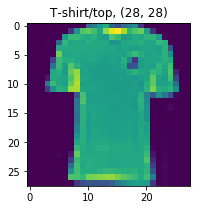

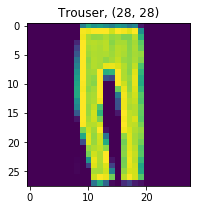

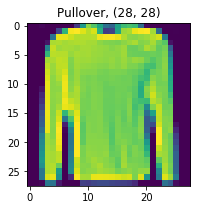

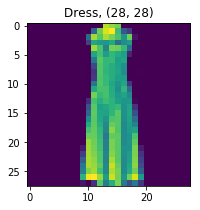

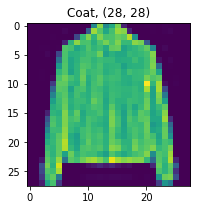

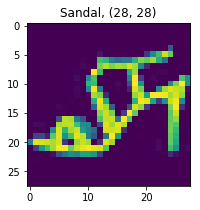

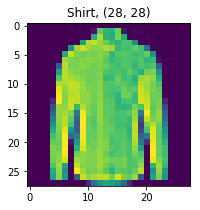

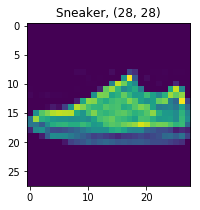

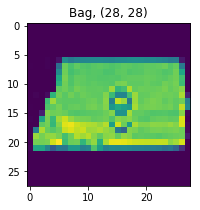

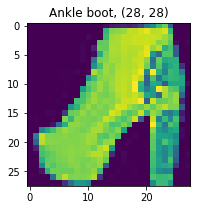

In [4]:
%%capture --no-display
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title):
    img = img / 2 + 0.5
    npimg = img.numpy()[0]
    plt.figure(figsize=(3,3))
    plt.title(title + ', ' + str(npimg.shape))
    plt.imshow(np.transpose(npimg, (0, 1)))


for i in range(len(classes)):
    dataiter = iter(trainloader)
    while True:
        image, label = dataiter.next()
        if label[0] == i:
            break
    imshow(image[0], classes[label[0]])


In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
def compute_loss_accuracy(dataloader, net, criterion):
    count = 0
    full_loss = 0
    
    correct_predictions = 0
    all_predictions = 0
    with torch.no_grad():
        for data in dataloader:
            if (count >= len(dataloader) // 10):
                break
            count += 1
            inputs, labels = data

            outputs = net(inputs)

            loss = criterion(outputs, labels)
            full_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            # print(predicted, labels, predicted == labels, torch.sum(predicted == labels))
            
            all_predictions += labels.shape[0]
            correct_predictions += torch.sum(predicted == labels).item()
            
    full_loss /= count
    
    return (full_loss, correct_predictions / all_predictions)

In [8]:
%%capture --no-stdout
trainloss = []
trainacc = []
testloss = []
testacc = []
for epoch in range(2):  # loop over the dataset multiple times

    #running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        #running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            #print('[%d, %5d] loss: %.3f' %
            #      (epoch + 1, i + 1, running_loss / 2000))
            #running_loss = 0.0
            
            loss, acc = compute_loss_accuracy(trainloader, net, criterion)
            trainloss.append(loss)
            trainacc.append(acc)
            
            loss, acc = compute_loss_accuracy(testloader, net, criterion)
            testloss.append(loss)
            testacc.append(acc)
            
            print('[%d, %5d] test loss: %.3f, test accuracy: %.3f' %
                  (epoch + 1, i + 1, loss, acc))
print('Finished Training')

[1,  2000] test loss: 0.775, test accuracy: 0.705
[1,  4000] test loss: 0.620, test accuracy: 0.773
[1,  6000] test loss: 0.580, test accuracy: 0.774
[1,  8000] test loss: 0.586, test accuracy: 0.784
[1, 10000] test loss: 0.537, test accuracy: 0.810
[1, 12000] test loss: 0.511, test accuracy: 0.804
[1, 14000] test loss: 0.443, test accuracy: 0.824
[2,  2000] test loss: 0.418, test accuracy: 0.845
[2,  4000] test loss: 0.423, test accuracy: 0.841
[2,  6000] test loss: 0.399, test accuracy: 0.849
[2,  8000] test loss: 0.417, test accuracy: 0.839
[2, 10000] test loss: 0.395, test accuracy: 0.860
[2, 12000] test loss: 0.365, test accuracy: 0.870
[2, 14000] test loss: 0.365, test accuracy: 0.873
Finished Training


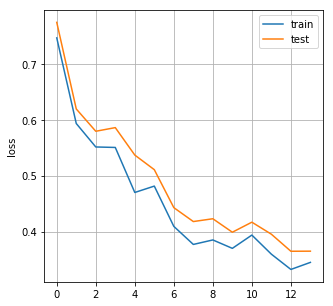

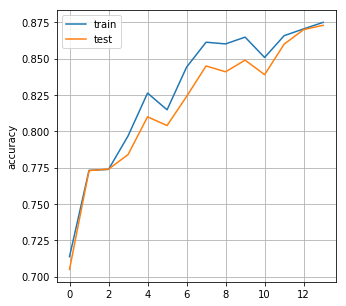

In [17]:

xs = np.arange(len(trainloss))
plt.figure(figsize=(5,5))
plt.plot(xs, np.array(trainloss), label='train')
plt.plot(xs, np.array(testloss), label='test')
plt.legend()
plt.grid()
plt.ylabel('loss')
plt.show()

plt.figure(figsize=(5,5))
plt.plot(xs, np.array(trainacc), label='train')
plt.plot(xs, np.array(testacc), label='test')
plt.legend()
plt.grid()
plt.ylabel('accuracy')
plt.show()

In [10]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        #print(outputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of T-shirt/top : 80 %
Accuracy of Trouser : 94 %
Accuracy of Pullover : 71 %
Accuracy of Dress : 90 %
Accuracy of  Coat : 65 %
Accuracy of Sandal : 97 %
Accuracy of Shirt : 72 %
Accuracy of Sneaker : 92 %
Accuracy of   Bag : 96 %
Accuracy of Ankle boot : 92 %
